In [1]:
import torch
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from lavis.common.gradcam import getAttMap
from lavis.models import load_model_and_preprocess

#### Load an example image and question

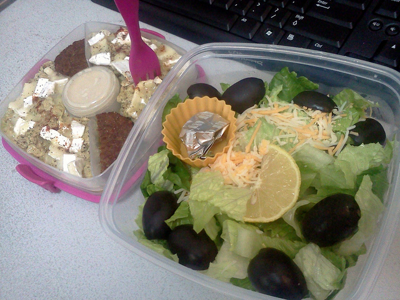

What is the black objects on the salad called?


In [2]:
raw_image = Image.open("./demo.png").convert("RGB")
display(raw_image.resize((400, 300)))
question = "What is the black objects on the salad called?"
print(question)

In [3]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### Load PNP-VQA model

In [ ]:
model, vis_processors, txt_processors = load_model_and_preprocess(name="pnp_vqa", model_type="base", is_eval=True, device=device)

#### Preprocess image and text inputs

In [14]:
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
question = txt_processors["eval"](question)

samples = {"image": image, "text_input": [question]}

#### Image-Question Matching 
Compute the relevancy score of image patches with respect to the question using GradCAM

In [15]:
samples = model.forward_itm(samples=samples)

Question: what is the black objects on the salad called?


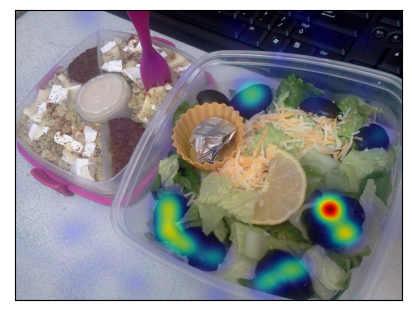

In [16]:
# Gradcam visualisation
dst_w = 720
w, h = raw_image.size
scaling_factor = dst_w / w

resized_img = raw_image.resize((int(w * scaling_factor), int(h * scaling_factor)))
norm_img = np.float32(resized_img) / 255
gradcam = samples['gradcams'].reshape(24,24)

avg_gradcam = getAttMap(norm_img, gradcam, blur=True)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(avg_gradcam)
ax.set_yticks([])
ax.set_xticks([])
print('Question: {}'.format(question))

#### Image Captioning
Generate question-guided captions based on the relevancy score

In [17]:
samples = model.forward_cap(samples=samples, num_captions=50, num_patches=20)
print('Examples of question-guided captions: ')
samples['captions'][0][:5]

Examples of question-guided captions: 


['salad salad side salad salad salad salad salad salad salad salad salad healthy side salad salad',
 'olive black lunch salad salad container bent vegetable salad salad, containers container in lunch containers',
 'two plastic containers of olives, olives, olives and a salad with',
 'a bowl has a salad with a black olive, olives, and grapes,',
 'tray black black left lunch black olive to black purple in next salad black black salad']

#### Question Answering
Answer the question by using the captions

In [18]:
pred_answers = model.forward_qa(samples, num_captions=50)
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))

Question: what is the black objects on the salad called? 
Predicted answer: black olives
